<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

In [ ]:
#@title
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
#@title
from sklearn.model_selection import train_test_split
data, attrs = fetch_dataset()
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [ ]:
#@title
plt.imshow(train_photos[0])

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy
features = 128
init_channels = 64
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.encoder = nn.Sequential(
        nn.Linear(in_features=12288, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=features)
      )
      self.decoder = nn.Sequential(
        nn.Linear(in_features=features, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=12288)
      )
      
    def forward(self, x):
      #latent = self.lin(self.encoder(x).view(-1, 1024))
      print(self.flatten(x).shape)
      latent = self.encoder(self.flatten(x))
      #print(latent.shape)
      reconstructed = self.decoder(latent).view(-1, 64, 64, 3)
      return reconstructed, latent
    #def sample(self, z):
        #generated = self.decoder(z)
        #generated = torch.sigmoid(generated)
        #generated = generated.view(-1, 64, 64, 3)
        #return generated

In [ ]:
#@title
'''nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3,padding=1),
        nn.BatchNorm2d(num_features= 64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3,padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3,padding=1),
        nn.BatchNorm2d(num_features= 32),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3,padding=1),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3,padding=1),
        nn.BatchNorm2d(num_features= 16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3,padding=1),
    )
      self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True), 

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True), 

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True), 

        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True), 

        nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)'''
        self.encoder = nn.Sequential(
        nn.Conv2d(3, init_channels, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels, init_channels*2, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*4, init_channels*8, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*8, 1024, kernel_size=3, stride=2, padding=1)
        )
      '''
      self.lin = nn.Sequential(
           nn.Linear(1024, 2048),
           nn.Linear(2048, features),
           nn.Linear(features, 2048),
           nn.Linear(2048 ,features)
           
      )
      '''
      self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1024, init_channels*8, kernel_size=3, stride=2,  padding=1), 
        nn.ConvTranspose2d(init_channels*8, init_channels*4, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels*4, init_channels*2, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels, 3, kernel_size=3, stride=2, padding=1)
      )
  

IndentationError: ignored

In [ ]:
#@title
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
        nn.Conv2d(3, init_channels, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels, init_channels*2, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*4, init_channels*8, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels*8, 1024, kernel_size=3, stride=2, padding=1)
        )
      
      self.lin = nn.Sequential(
           nn.Linear(1024, 2048),
           nn.Linear(2048, features),
           nn.Linear(features, 2048),
           nn.Linear(2048 ,features)
      )
        
      self.decoder = nn.Sequential(
        nn.ConvTranspose2d(features, init_channels*8, kernel_size=3, stride=2,  padding=1), 
        nn.ConvTranspose2d(init_channels*8, init_channels*4, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels*4, init_channels*2, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size=3, stride=2, padding=1), 
        nn.ConvTranspose2d(init_channels, init_channels, kernel_size=3, stride=2, padding=1),
        nn.ConvTranspose2d(init_channels, init_channels, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(init_channels, init_channels, kernel_size=3, stride=1, padding=2),
        nn.Conv2d(init_channels, 3, kernel_size=4, stride=1, padding=0)
      )
      
    def forward(self, x):
      latent = self.lin(self.encoder(x).view(-1, 1024))
      #print(latent.shape)
      #latent = self.encoder(x)
      reconstructed = self.decoder(latent.view(-1, 128, 2, 2))
      return reconstructed, latent

In [ ]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from torchsummary import summary
IMG_SIZE = (256, 256)
summary(model, (64, 64, 3))

torch.Size([2, 12288])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
           Flatten-2                [-1, 12288]               0
            Linear-3                 [-1, 1024]      12,583,936
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
           Linear-10                  [-1, 256]          33,024
             ReLU-11                  [-1, 256]               0
           Linear-12                  [-1, 512]         131,584
             ReLU-13                  [-1, 512]               0
           Linea

In [ ]:
for epoch in range(n_epochs):
    print(epoch)
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch = X_batch.float()
        reconstructed, _ = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          X_batch = X_batch.view(-1, 3, 64, 64).float()
          reconstructed, _ = model(X_batch.to(device))
          loss = loss_fn(reconstructed.view(-1, 3, 64, 64), X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

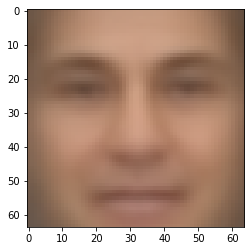

In [ ]:
reconstructed, latent = model(X_batch.to(device))
reconstruction = reconstructed.view(-1, 64, 64, 3)
result = reconstruction.cpu().detach().numpy()
plt.imshow(result[13])

In [ ]:
print(12288/1024)

12.0


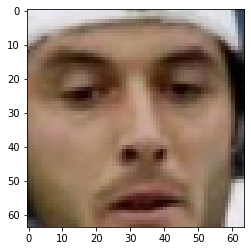

In [ ]:
plt.imshow(X_batch[13].view(64, 64, 3))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, <latent_space_dim>)
output = <скормите z декодеру>
<выведите тут полученные картинки>

SyntaxError: ignored

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
<ваш код здесь>

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

In [ ]:
import torchvision.transforms

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Data Loader 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
y = []
for i in range(10000):
  y.append(test_dataset[i][-1])


In [ ]:
labels.shape

torch.Size([10000, 10])

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

        

    def encode(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.gaussian_sampler(mu, logVar)
        out = self.decode(z)
        return mu, logVar, out

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

И обучим модель:

In [ ]:
#@title
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = VAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

** здеся**

In [ ]:
from IPython.display import clear_output
def trainVae(autoencoder,train_loader,val_loader, optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3),
             criterion = loss_vae,
             device = 'cuda:0' if torch.cuda.is_available() else 'cpu', epochs = 15):
  train_losses = []
  val_losses = []

  for i in range(epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    print('Epoch(train): ', i+1)
    
    #обучение
    for batch_idx, (data, _) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      mu, logsigma, reconstruction = autoencoder(data)
      reconstruction = reconstruction.view(-1, 28, 28)
      loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
      loss.backward()
      optimizer.step()
      train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    autoencoder.eval()
    val_losses_per_epoch = []
    #валидация
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
          data = data.to(device)
          mu, logsigma, reconstruction = autoencoder(data)
          reconstruction = reconstruction.view(-1, 28, 28)
          loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    #plt.figure(figsize=(8, 20))
    clear_output(wait=True)

    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(data[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstruction[k].cpu().detach().numpy(), cmap='gray')
      plt.title('Output')
      plt.axis('off')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()
  return train_losses, val_losses, mu, logsigma

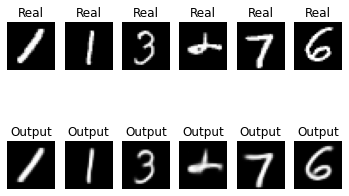

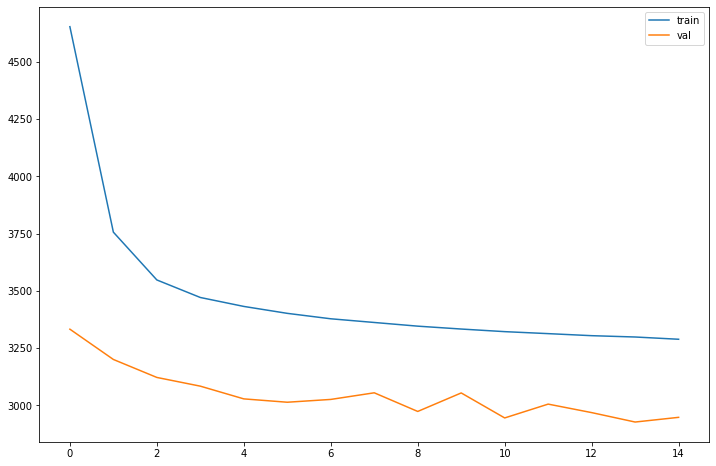

In [ ]:
train_losses, val_losses, mu, logsigma = trainVae(autoencoder,train_loader,val_loader)

In [ ]:
torch.mean(logsigma)

tensor(-0.1952, device='cuda:0')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

torch.float32


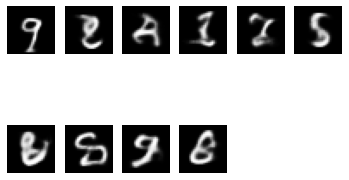

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных\
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])
z = trans(np.array([np.random.normal(0, 0.8078, 256) for i in range(10)])).float().to(device).view(10, 256)
print(z.dtype)
output = autoencoder.decode(z)
for k in range(10):
      plt.subplot(2, 6, k+1)
      plt.imshow(output[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.axis('off')

      

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
del z

In [ ]:
flag = False
for batch_idx, (data, _) in enumerate(test_loader):
    optimizer.zero_grad()
    data = data.to(device)
    mu, logsigma = autoencoder.encode(data)
    if flag:
      z = torch.cat((z, autoencoder.gaussian_sampler(mu, logsigma)), 0)
    else:
      z = autoencoder.gaussian_sampler(mu, logsigma)
      flag = True
z = z.cpu().detach().numpy()
z.shape

(10000, 256)

In [ ]:
from sklearn.manifold import TSNE
embed = TSNE(
    n_components=2, # значение по умолчанию=2. Размерность вложенного пространства.
    perplexity=10, # значение по умолчанию=30.0. Перплексия связана с количеством ближайших соседей, которое используется в других алгоритмах обучения на множествах.
    early_exaggeration=12, # значение по умолчанию=12.0. Определяет, насколько плотными будут естественные кластеры исходного пространстве во вложенном пространстве и сколько места будет между ними. 
    learning_rate=200, # значение по умолчанию=200.0. Скорость обучения для t-SNE обычно находится в диапазоне [10.0, 1000.0]. Если скорость обучения слишком высока, данные могут выглядеть как "шар", в котором любая точка приблизительно равноудалена от ближайших соседей. Если скорость обучения слишком низкая, большинство точек могут быть похожими на сжатое плотное облако с незначительным количеством разбросов. 
    n_iter=5000, # значение по умолчанию=1000. Максимальное количество итераций для оптимизации. Должно быть не менее 250.
    n_iter_without_progress=300, # значение по умолчанию=300. Максимальное количество итераций без прогресса перед прекращением оптимизации, используется после 250 начальных итераций с ранним преувеличением.
    min_grad_norm=0.0000001, # значение по умолчанию=1e-7. Если норма градиента ниже этого порога, оптимизация будет остановлена.
    metric='euclidean', # значение по умолчанию='euclidean', Метрика, используемая при расчете расстояния между экземплярами в массиве признаков.
    init='random',# значение по умолчанию='random'. Инициализация вложения.
    verbose=0, # значение по умолчанию=0. Уровень детализации.
    random_state=42, # экземпляр RandomState или None, по умолчанию=None. Определяет генератор случайных чисел. Передача int для воспроизводимых результатов при многократном вызове функции.
    method='barnes_hut', # значение по умолчанию='barnes_hut'. По умолчанию алгоритм вычисления градиента использует аппроксимацию Барнса-Хата, работающую в течение времени O(NlogN). метод='exact' будет работать по более медленному, но точному алгоритму за время O(N^2). Следует использовать точный алгоритм, когда количество ошибок ближайших соседей должно быть ниже 3%.
    angle=0.5, # значение по умолчанию=0.5. Используется только если метод='barnes_hut' Это компромисс между скоростью и точностью в случае T-SNE с применением алгоритма Барнса-Хата.
    n_jobs=-1, # значение по умолчанию=None. Количество параллельных заданий для поиска соседей. -1 означает использование всех процессоров.
)

# Преобразование X
z = embed.fit_transform(z)

In [ ]:
y = []
for i in range(10000):
  y.append(test_dataset[i][-1])

In [ ]:
import pandas
y = pandas.Series(y)

In [ ]:
import plotly.express as px
fig = px.scatter(None, x=z[:,0], y=z[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=y.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
train_dataset

TypeError: ignored

In [ ]:
class CVAE(nn.Module):
    def __init__(self, imgChannels = 1, zDim = 256, featureDim = 32*20*20):
        super(CVAE, self).__init__()
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC = nn.Linear(featureDim + 10, featureDim)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        #self.encFC = nn.Linear(featureDim + 10, featureDim)
        self.decFC1 = nn.Linear(zDim + 10, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encode(self, x, class_num):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        x = torch.cat((x, class_num), 1)
        x = self.encFC(x)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, x, class_num):
        x = torch.cat((x, class_num), 1)
        x = F.relu(self.decFC1(x))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
        return reconstruction

    def forward(self, x, labels):
        mu, logVar = self.encode(x, labels)
        z = self.gaussian_sampler(mu, logVar)
        out = self.decode(z, labels)
        return mu, logVar, out

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = CVAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
from IPython.display import clear_output
def trainVae(autoencoder,train_loader,val_loader,labels, optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3),
             criterion = loss_vae,
             device = 'cuda:0' if torch.cuda.is_available() else 'cpu', epochs = 10):
  train_losses = []
  val_losses = []

  for i in range(epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    print('Epoch(train): ', i+1)
    
    #обучение
    for batch_idx, (data, label) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      labels = F.one_hot(label, 10)
      labels = labels.to(device)
      mu, logsigma, reconstruction = autoencoder(data, labels)
      reconstruction = reconstruction.view(-1, 28, 28)
      loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
      loss.backward()
      optimizer.step()
      train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    autoencoder.eval()
    val_losses_per_epoch = []
    #валидация
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(train_loader):
          data = data.to(device)
          labels = F.one_hot(label, 10)
          labels = labels.to(device)
          mu, logsigma, reconstruction = autoencoder(data, labels)
          reconstruction = reconstruction.view(-1, 28, 28)
          loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    #plt.figure(figsize=(8, 20))
    clear_output(wait=True)

    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(data[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstruction[k].cpu().detach().numpy(), cmap='gray')
      plt.title('Output')
      plt.axis('off')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()
  return train_losses, val_losses, mu, logsigma

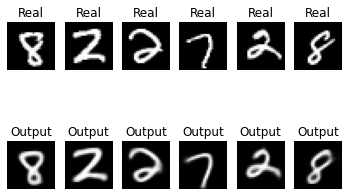

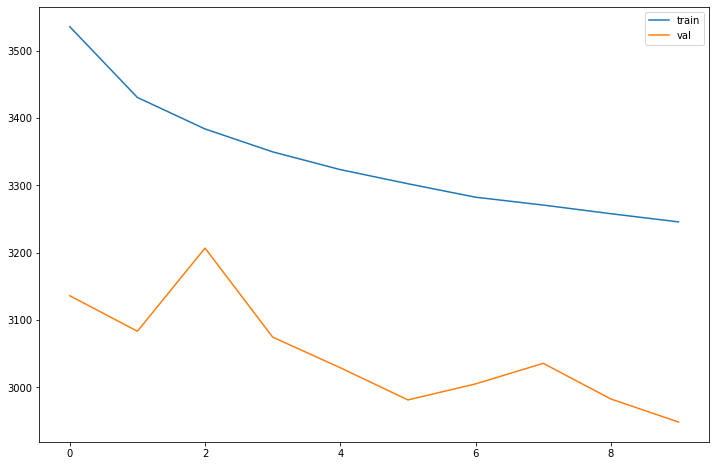

In [ ]:
train_losses, val_losses, mu, logsigma = trainVae(autoencoder,train_loader,val_loader, labels)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

torch.Size([10, 256])


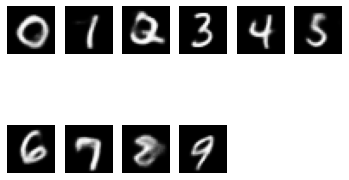

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных\
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])
z = trans(np.array([np.random.normal(0, 0.8078, 256) for i in range(10)])).float().to(device).view(10, 256)
label = [0,1,2,3,4,5,6,7,8,9]
label = torch.as_tensor(label)
labels = F.one_hot(label, 10)
labels.to(device)

print(z.shape)
output = autoencoder.decode(z,labels.to(device))
for k in range(10):
      plt.subplot(2, 6, k+1)
      plt.imshow(output[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.axis('off')

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

In [ ]:
del z

In [ ]:
flag = False
for batch_idx, (data, label) in enumerate(test_loader):
    optimizer.zero_grad()
    data = data.to(device)
    labels = F.one_hot(label, 10)
    labels = labels.to(device)
    mu, logsigma = autoencoder.encode(data, labels)
    if flag:
      z = torch.cat((z, autoencoder.gaussian_sampler(mu, logsigma)), 0)
    else:
      z = autoencoder.gaussian_sampler(mu, logsigma)
      flag = True
z = z.cpu().detach().numpy()
z.shape

(10000, 256)

In [ ]:
from sklearn.manifold import TSNE
embed = TSNE(
    n_components=2, # значение по умолчанию=2. Размерность вложенного пространства.
    perplexity=10, # значение по умолчанию=30.0. Перплексия связана с количеством ближайших соседей, которое используется в других алгоритмах обучения на множествах.
    early_exaggeration=12, # значение по умолчанию=12.0. Определяет, насколько плотными будут естественные кластеры исходного пространстве во вложенном пространстве и сколько места будет между ними. 
    learning_rate=200, # значение по умолчанию=200.0. Скорость обучения для t-SNE обычно находится в диапазоне [10.0, 1000.0]. Если скорость обучения слишком высока, данные могут выглядеть как "шар", в котором любая точка приблизительно равноудалена от ближайших соседей. Если скорость обучения слишком низкая, большинство точек могут быть похожими на сжатое плотное облако с незначительным количеством разбросов. 
    n_iter=5000, # значение по умолчанию=1000. Максимальное количество итераций для оптимизации. Должно быть не менее 250.
    n_iter_without_progress=300, # значение по умолчанию=300. Максимальное количество итераций без прогресса перед прекращением оптимизации, используется после 250 начальных итераций с ранним преувеличением.
    min_grad_norm=0.0000001, # значение по умолчанию=1e-7. Если норма градиента ниже этого порога, оптимизация будет остановлена.
    metric='euclidean', # значение по умолчанию='euclidean', Метрика, используемая при расчете расстояния между экземплярами в массиве признаков.
    init='random',# значение по умолчанию='random'. Инициализация вложения.
    verbose=0, # значение по умолчанию=0. Уровень детализации.
    random_state=42, # экземпляр RandomState или None, по умолчанию=None. Определяет генератор случайных чисел. Передача int для воспроизводимых результатов при многократном вызове функции.
    method='barnes_hut', # значение по умолчанию='barnes_hut'. По умолчанию алгоритм вычисления градиента использует аппроксимацию Барнса-Хата, работающую в течение времени O(NlogN). метод='exact' будет работать по более медленному, но точному алгоритму за время O(N^2). Следует использовать точный алгоритм, когда количество ошибок ближайших соседей должно быть ниже 3%.
    angle=0.5, # значение по умолчанию=0.5. Используется только если метод='barnes_hut' Это компромисс между скоростью и точностью в случае T-SNE с применением алгоритма Барнса-Хата.
    n_jobs=-1, # значение по умолчанию=None. Количество параллельных заданий для поиска соседей. -1 означает использование всех процессоров.
)

# Преобразование X
z = embed.fit_transform(z)

In [ ]:
y = []
for i in range(10000):
  y.append(test_dataset[i][-1])

In [ ]:
import pandas
y = pandas.Series(y)

In [ ]:
import plotly.express as px
fig = px.scatter(None, x=z[:,0], y=z[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=y.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

NameError: ignored

In [ ]:
import torchvision.transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Data Loader 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

        

    def encode(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.gaussian_sampler(mu, logVar)
        out = self.decode(z)
        return mu, logVar, out

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = VAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-2)

In [ ]:
from IPython.display import clear_output
def trainVae(autoencoder,train_loader,val_loader, optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3),
             criterion = loss_vae, noise_factor = 0.1, 
             device = 'cuda:0' if torch.cuda.is_available() else 'cpu', epochs = 10):
  train_losses = []
  val_losses = []

  for i in range(epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    print('Epoch(train): ', i+1)
    
    #обучение
    for batch_idx, (data, _) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      datal = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 
      datal = datal.float()
      mu, logsigma, reconstruction = autoencoder(datal)
      reconstruction = reconstruction.view(-1, 28, 28)
      loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
      loss.backward()
      optimizer.step()
      train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    autoencoder.eval()
    val_losses_per_epoch = []
    #валидация
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
          data = data.to(device)
          datal = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size= data.shape)
          datal = datal.float()
          mu, logsigma, reconstruction = autoencoder(datal)
          reconstruction = reconstruction.view(-1, 28, 28)
          loss = criterion(data.view(-1, 28, 28), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    #plt.figure(figsize=(8, 20))
    clear_output(wait=True)

    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(datal[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstruction[k].cpu().detach().numpy(), cmap='gray')
      plt.title('Output')
      plt.axis('off')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()
  return train_losses, val_losses, mu, logsigma

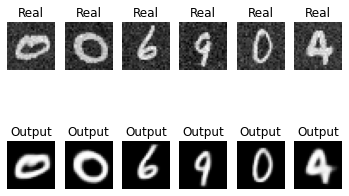

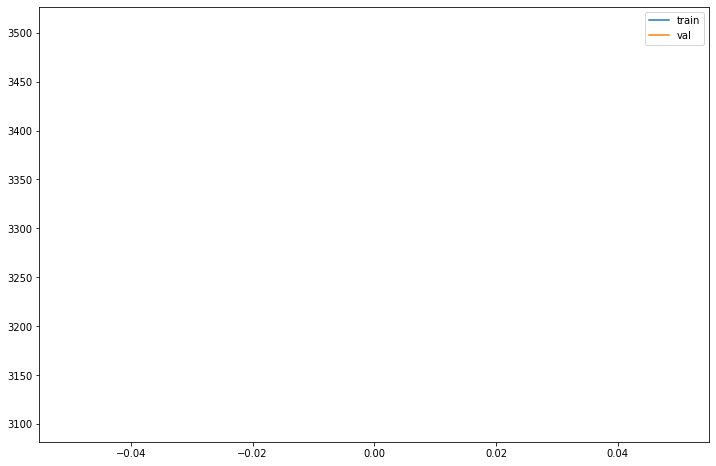

Epoch(train):  2


In [ ]:
train_losses, val_losses, mu, logsigma = trainVae(autoencoder,train_loader,val_loader)

In [ ]:
for batch_idx, (data, _) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      datal = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 
      datal = data.float()
      mu, logsigma, reconstruction = autoencoder(datal)
      reconstruction = reconstruction.view(-1, 28, 28)
      

KeyboardInterrupt: ignored

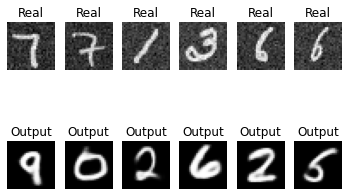

<Figure size 864x576 with 0 Axes>

In [ ]:
datal = data + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 
datal = datal.float()
for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(datal[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.title('Real')
      plt.axis('off')
    
      plt.subplot(2, 6, k+7)
      plt.imshow(reconstruction[k].cpu().detach().numpy(), cmap='gray')
      plt.title('Output')
      plt.axis('off')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
plt.show()
plt.figure(figsize=(12, 8))

plt.show()

torch.Size([10, 256])


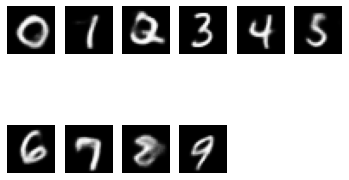

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных\
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])
z = trans(np.array([np.random.normal(0, 0.8078, 256) for i in range(10)])).float().to(device).view(10, 256)
label = [0,1,2,3,4,5,6,7,8,9]
label = torch.as_tensor(label)
labels = F.one_hot(label, 10)
labels.to(device)

print(z.shape)
output = autoencoder.decode(z,labels.to(device))
for k in range(10):
      plt.subplot(2, 6, k+1)
      plt.imshow(output[k].view( 28, 28).cpu().detach().numpy(), cmap='gray')
      plt.axis('off')

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
def getLatent(model,dataset):
  flag = False
  for data, _ in dataset:
    data = data.to(device)
    #print(data.shape)
    mu, logVar = model.encode(data)
    if flag:
      latent = torch.cat([latent, model.gaussian_sampler(mu, logVar)], dim=0)
    else:
      latent = model.gaussian_sampler(mu, logVar)
      flag = True
  return latent

In [ ]:
codes = getLatent(autoencoder,test_loader)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# обучаем LSHForest
codes = codes.cpu().detach().numpy()

NameError: ignored

In [ ]:
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей
  image = image.to(device)
  mu, logVar = autoencoder.encode(image.view(1, 1, 28, 28))

  code = autoencoder.gaussian_sampler(mu, logVar).cpu().detach().numpy()   
  distances, indices = nn.kneighbors(code)
  #t = torch.from_numpy(a)
  X = autoencoder.decode(torch.from_numpy(codes[indices]).to(device)).view(-1, 28, 28)
  return distances, X

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(10):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().detach().numpy())
        #plt.title("Dist=%.3f"%distances[i])
    plt.show()

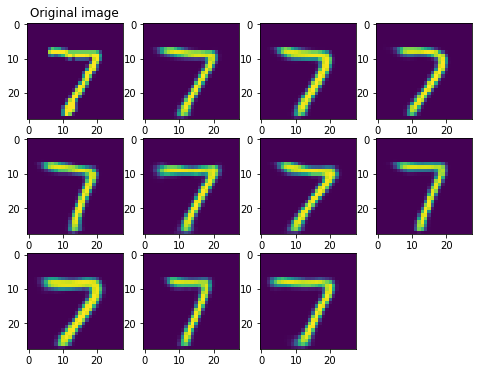

In [ ]:
show_similar(test_dataset[0][0].view(28,28))